In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

Saving book.tif to book (1).tif


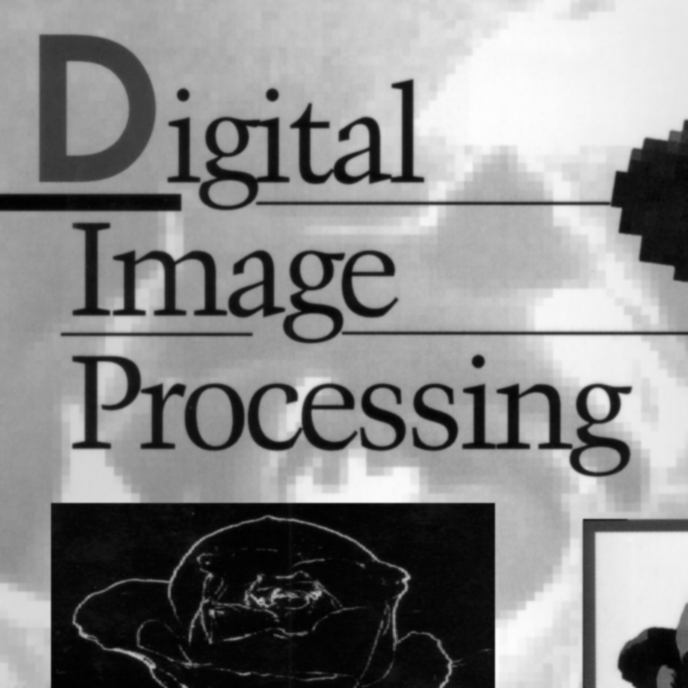

In [59]:
from google.colab import files
myfile = files.upload()

I = cv2.imread('book.tif', cv2.IMREAD_GRAYSCALE)

from google.colab.patches import cv2_imshow 
cv2_imshow(I)

In [60]:
# Step2. 지금까지 구현한 Motion Blur Filter, Gaussian Noise, Gaussian LPF를 사용해야합니다. 이전까지 구현한 코드를 사용하세요.

def MotionBlur(img , a=0.05, b=0.05, T=1 , alpha = 75):
    img_norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img_norm_padded = np.pad(img_norm, ((0, img_norm.shape[0]), (0,img_norm.shape[1])), 'constant', constant_values = 0)
    img_norm_padded_fftshift = np.fft.fftshift(img_norm_padded) 
    img_norm_padded_fft =  np.fft.fft2(img_norm_padded_fftshift)

    P, Q = img_norm_padded.shape
    v = np.linspace(0, P-1, P, dtype= int) # height
    h = np.linspace(0, Q-1, Q, dtype= int) # width
    [X, Y] = np.meshgrid(h-P//2, v-Q//2)
    H_kernel = (T/(np.pi*(X*a + Y*b)))*np.sin(np.pi*(X*a + Y*b))*np.exp((-1j)*np.pi*(X*a + Y*b))   
    H_kernel[np.isnan(H_kernel)] = T

    img_motionblurred_fft = H_kernel * img_norm_padded_fft
    img_motionblurred_centered  = np.fft.ifft2(img_motionblurred_fft).real
    img_motionblurred = np.fft.ifftshift(img_motionblurred_centered)
    img_motionblurred = img_motionblurred[0:I.shape[0], 0:I.shape[1]].copy()
    img_motionblurred = np.clip(img_motionblurred * 255 + alpha , 0 , 255)
    img_motionblurred = img_motionblurred.astype(np.uint8)

    return img_motionblurred

def GaussianNoise(img, std = 5):
    height, width = img.shape
    # 평균이 0 표준편차가 std인 noise
    gaussian_noise = std * np.random.randn(height, width) + 0

    return gaussian_noise

def GaussianLPF(img, D_zero =50):
    img_padded = np.pad(img, ((0, img.shape[0]), (0,img.shape[1])), 'constant', constant_values = 0)
    f = np.fft.fft2(img_padded)
    f_shift = np.fft.fftshift(f)
     
    P, Q = img_padded.shape
    v = np.linspace(0, P-1, P) # height
    h = np.linspace(0, Q-1, Q) # width
    [X, Y] = np.meshgrid(h, v)                                   
    lpf = np.exp(((X-Q/2)**2+(Y-P/2)**2)/(-2*(D_zero**2)))
    
    mul = f_shift * lpf
    if_centered = np.fft.ifftshift(mul)
    if_ = np.fft.ifft2(if_centered)

    glpfs = np.abs(if_)
    glpfs = np.clip(np.rint(glpfs), 0, 255) 
    glpfs = glpfs.astype(np.uint8)
    glpfs = glpfs[0:I.shape[0], 0:I.shape[1]].copy()
    
    return glpfs



In [61]:
# Step3.  원본 이미지에 Motion Blur를 적용하세요. (a=0.05, b=0.05, T=1)

I_MB = MotionBlur(I,a=0.05, b=0.05, T=1)

# Step4. Step3의 결과에 Gaussian Noise를 더하세요. (D_zero는 자유롭게)

I_GN_noise = GaussianNoise(I_MB, std = 40)
I_GN = I_MB + I_GN_noise
I_GN = np.clip(I_GN,0,255)
I_GN = cv2.convertScaleAbs(I_GN)

# Step5. Step4의 결과에 Gaussian LPF를 적용해 Noise를 줄여주세요. (D_zero는 자유롭게)

I_GLPF = GaussianLPF(I_GN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


In [124]:
def InverseFilter(img, a=0.05, b=0.05, T=1, alpha = 75):
    img_norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img_norm_padded = np.pad(img_norm, ((0, img_norm.shape[0]), (0,img_norm.shape[1])), 'constant', constant_values = 0)

    img_norm_padded_fftshift = np.fft.fftshift(img_norm_padded) 
    img_norm_padded_fft =  np.fft.fft2(img_norm_padded_fftshift)

    P, Q = img_norm_padded.shape
    v = np.linspace(0, P-1, P, dtype= int) # height
    h = np.linspace(0, Q-1, Q, dtype= int) # width
    [X, Y] = np.meshgrid(h-P//2, v-Q//2)
    H_kernel = (T/(np.pi*(X*a + Y*b)))*np.sin(np.pi*(X*a + Y*b))*np.exp((-1j)*np.pi*(X*a + Y*b))   
    H_kernel[np.isnan(H_kernel)] = T

    InvF = img_norm_padded_fft / H_kernel

    result = np.fft.ifft2(InvF).real

    result2 = np.fft.ifftshift(result)
    result2 = result2[0:img.shape[0], 0:img.shape[1]].copy() 
    result2 = np.clip(result2 * 255 , 0, 255)
    result2 = result2.astype(np.uint8) 

    return result2


I_IF = InverseFilter(I_GLPF)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


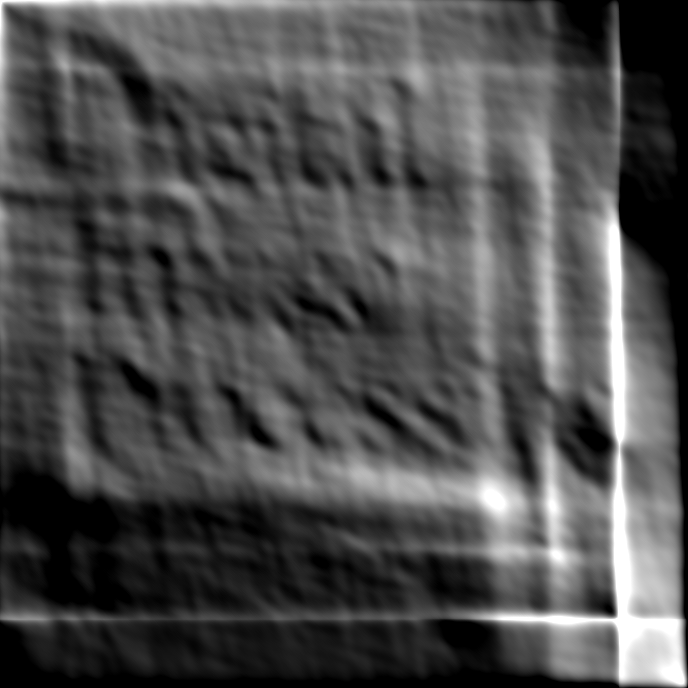

In [95]:
# Step6. Step6. Step5의 결과를 다음장에 설명되어 있는 Wiener Filter를 구현해 적용하세요.

def WienerFilter(img , a=0.05, b=0.05, T=1, k=0.01, alpha = 45):
    #Step_A
    img_norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img_norm_padded = np.pad(img_norm, ((0, img_norm.shape[0]), (0,img_norm.shape[1])), 'constant', constant_values = 0)

    #Step_B
    img_norm_padded_fftshift = np.fft.fftshift(img_norm_padded) 
    img_norm_padded_fft =  np.fft.fft2(img_norm_padded_fftshift)

    #Step_C
    P, Q = img_norm_padded.shape
    v = np.linspace(0, P-1, P, dtype= int) # height
    h = np.linspace(0, Q-1, Q, dtype= int) # width
    [X, Y] = np.meshgrid(h-P//2, v-Q//2)
    H_kernel = (T/(np.pi*(X*a + Y*b)))*np.sin(np.pi*(X*a + Y*b))*np.exp((-1j)*np.pi*(X*a + Y*b))   
    H_kernel[np.isnan(H_kernel)] = T
    
    Step_C = H_kernel * np.conj(H_kernel)

    Step_D = img_norm_padded_fft * Step_C

    Step_E = H_kernel*(Step_C + k)

    Step_F = Step_D / Step_E

    Step_G = np.fft.ifft2(Step_F).real

    Step_H = np.fft.ifftshift(Step_G)
    Step_H = Step_H[0:img.shape[0], 0:img.shape[1]].copy() 
    Step_H = np.clip(Step_H * 255 + alpha , 0, 255)
    Step_H = Step_H.astype(np.uint8) 

    return Step_H

I_WF = WienerFilter(I_GLPF)

cv2_imshow(I_WF)

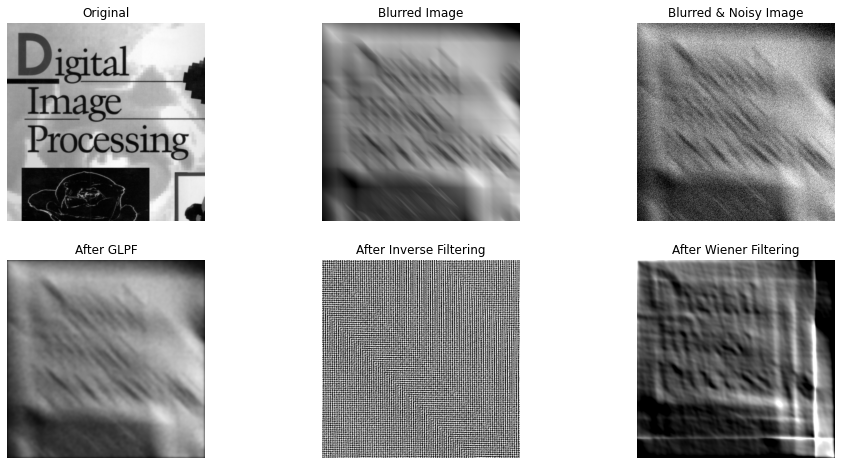

In [123]:
fig = plt.figure(figsize = (16, 8)) 
rows = 2
cols = 3
  
ax1 = fig.add_subplot(rows, cols, 1)
I_RGB = cv2.cvtColor(I, cv2.COLOR_GRAY2RGB)
ax1.imshow(I_RGB)
ax1.set_title('Original')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
I_MB_RGB = cv2.cvtColor(I_MB, cv2.COLOR_GRAY2RGB)
ax2.imshow(I_MB_RGB)
ax2.set_title('Blurred Image')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
I_GN_RGB = cv2.cvtColor(I_GN, cv2.COLOR_GRAY2RGB)
ax3.imshow(I_GN_RGB)
ax3.set_title('Blurred & Noisy Image')
ax3.axis("off")
 
ax4 = fig.add_subplot(rows, cols, 4)
I_GLPF_RGB = cv2.cvtColor(I_GLPF, cv2.COLOR_GRAY2RGB)
ax4.imshow(I_GLPF_RGB)
ax4.set_title('After GLPF')
ax4.axis("off")

ax5 = fig.add_subplot(rows, cols, 5)
I_IF_RGB = cv2.cvtColor(I_IF, cv2.COLOR_GRAY2RGB)
ax5.imshow(I_IF_RGB)
ax5.set_title('After Inverse Filtering')
ax5.axis("off")
 
ax6 = fig.add_subplot(rows, cols, 6)
I_WF_RGB = cv2.cvtColor(I_WF, cv2.COLOR_GRAY2RGB)
ax6.imshow(I_WF_RGB)
ax6.set_title('After Wiener Filtering')
ax6.axis("off")

plt.show()